
## 5G NR MIB and SIB1 Recovery

Before a mobile station (UE) can communicate with a 5G base station (gNodeB), it must first find the cell (cell ID), synchronize (time and frequency) with it, and read some basic information (MIB and SIB1).


To do this, it decodes two key messages:

-  MIB (Master Information Block) \- provides fundamental parameters required to access the network.
-  SIB1 (System Information Block Type 1) \- provides additional system configuration needed for the initial connection.

This implementation shows how a 5G receiver synchronizes and decodes these messages.

### A. Transmitter Side (Signal Generation)
-  The base station periodically transmits a Synchronization Signal Block (SSB).
-  Each SSB includes \- Primary Synchronization Signal (PSS), Secondary Synchronization Signal (SSS), and Physical Broadcast Channel (PBCH) which carries the MIB.
-  The SIB1 is carried on PDSCH (Physical Downlink Shared Channel).
### B. Wireless Channel (AWGN)
-  The signal is passed through a wireless channel with Additive White Gaussian Noise (AWGN).
-  Mathematically, the received signal is: r\[n\] = x\[n\] + w\[n\], where r\[n\] = received signal, x\[n\] = transmitted signal, w\[n\] = random noise with Gaussian distribution.
### C. Receiver Side

The receiver performs the following tasks:

-  Synchronization: Aligns timing and frequency using PSS and SSS.
-  Cell Identification: Determines the cell ID (NCellID) from detected PSS/SSS.
-  Demodulation: Demodulates PBCH to obtain the MIB.
-  Decoding: Uses the MIB information to decode PDCCH, PDSCH, and finally recover SIB1.

To synchronize and demodulate the received signal, receiver needs the following parameters to process the received waveform correctly:

| **Parameter** <br>  | **Meaning** <br>  | **Purpose** <br>   |
| :-- | :-- | :-- |
| Sample Rate <br>  | Number of samples per second <br>  | Used for OFDM demodulation and timing <br>   |
| Carrier Frequency (fPhaseComp) <br>  | RF center frequency of transmission <br>  | Used to correct phase rotation in received samples <br>   |
| MinChannelBW <br>  | Minimum allowed bandwidth (5, 10, or 40 MHz) <br>  | Helps determine CORESET 0 (control region) <br>   |
| SS Block Pattern <br>  | Defines SSB frequency and subcarrier spacing (Cases A\-E) <br>  | Helps decide search range and spacing <br>   |
| L\_max <br>  | Maximum number of SS/PBCH blocks (4, 8, or 64) in SS burst <br>  | Used for PBCH DMRS and descrambling <br>   |

### A. Generate Signal containing SS burst and SIB1

First, create an SS burst containing multiple SSBs at different symbol indices. Then generate SIB1, and finally generate the waveform containing both the SS burst and SIB1.

#### 1. SS Burst

An SS burst contains multiple SSB patterns (Case A \- Case G) depending on subcarrier spacing and carrier frequency range. It has a duration equal to half frame (5 subframe or 5 ms) and maximum number of SSBs per half frame depends on operating frequency band.

#### Generate SSB

An SSB occupies 240 subcarriers in frequency and 4 OFDM symbols in time. It is a self\-synchronization block containing PSS, SSS, PBCH, and PBCH\-DMRS, where the PBCH carries the MIB information. These components are transmitted in a specific pattern where PSS goes in first symbol SSB, SSS goes in 3rd symbol and PBCH along with DMRS goes in 2nd, 3rd, and 4th symbols.

#### Primary Synchronization Signal (PSS)

PSS is the first downlink used for radio synchronization. It helps UE to find out symbol boundary and helps UE to find out cell ID. It is generated using m\-sequence,  and occupies 127 subcarriers in frequency and 1 OFDM symbol in time.


$$\textrm{CellID}=3\cdot N_{\textrm{ID}\;}^1 +N_{\textrm{ID}\;\;}^2 ,\textrm{where}\;\textrm{CellID}\in \left\lbrace 0,1,2,\cdots 1007\right\rbrace$$

$${N_{\textrm{ID}}^2 \in \left\lbrace 0,1,\cdots 335\right\rbrace \;\textrm{and}\;N}_{\textrm{ID}}^2 \in \left\lbrace 0,1,2\right\rbrace$$

To achieve time synchronization, the gNodeB transmits the PSS signal. The UE locally generates all three possible PSS sequences and correlates them with the received signal. When the correlation exceeds a predefined threshold, it indicates the correct symbol timing.

#### Generate m\-sequence

This is a binary sequence of length 127. It is produced using the relation:


$$x(i+7)=\bigl(x(i+4)+x(i)\bigr)\textrm{mod}2$$

Initial state: $[x(6)\;x(5)\;x(4)\;x(3)\;x(2)\;x(1)\;x(0)]=[1,1,1,0,1,1,0]$


(Here $x(0)$ is the LSB).


After the initial 7 bits, each new $x(i)$ is computed as:


$$x(i)=(x(i-3)+x(i-7))\textrm{mod}2$$
#### Compute $m(n)$

For each $n=0,1,\ldots,126$:


$$m(n)=(n+43\cdot N_{ID}^2 )\textrm{mod}127$$

where $N_{ID}^2 \in \lbrace 0,1,2\rbrace$

#### Map to $d_{\textrm{PSS}} (n)$

Finally computes:


$$d_{\textrm{PSS}} (n)=1-2\cdot x\bigl(m(n)\bigr)$$

This maps:


$$x(m(n))=0\;\;\to \;\;d_{\textrm{PSS}} (n)=+1\;\,$$

$$x(m(n))=1\;\;\to \;\;d_{\textrm{PSS}} (n)=-1\;$$

This is a BPSK\-mapped sequence that is transmitted as the PSS sequence in 5G NR as per TS 38.211 by 3GPP.


In [1]:
% generate a 240×4 matrix to represent the SS/PBCH block
ssb = zeros([240 4])

ssb = 240x4
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0
     0     0     0     0


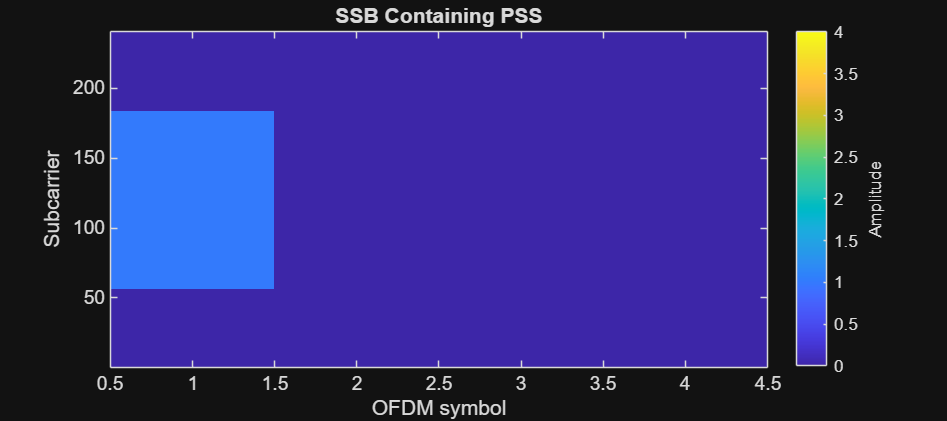

In [2]:
% generate PSS and PSS indices for a given cellID

cellID = 1;                  % Cell ID
pss = nrPSS(cellID);         % PSS sequence
pss_indices = nrPSSIndices;  % PSS sequence indices

% map the PSS into SSB
ssb(pss_indices) = 1 * pss;  % scale by beta=1 as per TS 38.211 Section 7.4.3.1.1

% plot the SSB containing PSS
figure('Position', [100 100 900 400])
imagesc(abs(ssb));
clim([0 4])
axis xy;
title('SSB Containing PSS');
ylabel('Subcarrier');
xlabel('OFDM symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Secondary Synchronization Signal (SSS)

It is same as PSS, takes 127 subcarriers in frequency and 1 OFDM symbol in time. It is always transmitted as a part of SSB along with PSS. SSS along with PSS helps UE to find cell ID and do frame synchronization. It is generated using m\-sequence.

#### Compute $m_0$ and $m_1$

$$m_0 =15\cdot \left\lfloor \frac{N_{ID}^1 }{112}\right\rfloor +5\cdot N_{ID}^2$$

$$m_1 =N_{ID}^1 \textrm{mod}112$$

 $m_0$ and $m_1$ define the cyclic shifts for $x_0$ and $x_1$.

#### Generate m\-sequence $x_0 (i)$

$$x_0 (i+7)=\bigl(x_0 (i)+x_0 (i+4)\bigr)\textrm{mod}2$$

Initial state: $[x_0 (6)\;x_0 (5)\;x_0 (4)\;x_0 (3)\;x_0 (2)\;x_0 (1)\;x_0 (0)]=[0,0,0,0,0,0,1]$

#### Generate m\-sequence $x_1 (i)$

$$x_1 (i+7)=\bigl(x_1 (i+1)+x_1 (i)\bigr)\textrm{mod}2$$

same initial state as $x_0 (i)$.

#### Compute $m_0 (n)$ and $m_1 (n)$

For each $n=0,1,\ldots,126$:


$$m_0 (n)=(n+m_0 )\textrm{mod}127$$

$$m_1 (n)=(n+m_1 )\textrm{mod}127$$
#### Generate $d_{SSS} (n)$

$$dSSS(n)=\bigl(1-2\cdot x_0 (m_0 (n))\bigr)\cdot \bigl(1-2\cdot x_1 (m_1 (n))\bigr)$$

This performs BPSK mapping, where:


$$x₀(m₀(n)),x₁(m₁(n))=0\to \;\textrm{contributes}\;\textrm{+1}$$

$$x₀(m₀(n)),x₁(m₁(n))=1\to \;\textrm{contributes}\;\textrm{-}\textrm{1}$$


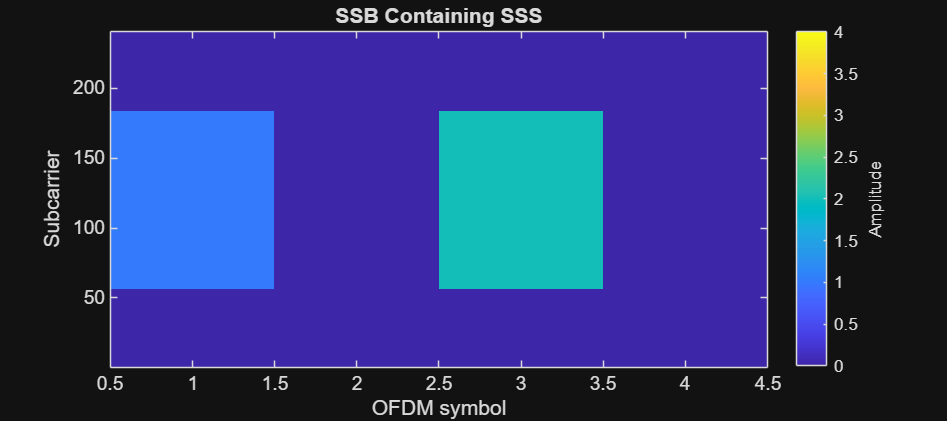

In [3]:
% generate the SSS and its indices and map it into SSB
sss = nrSSS(cellID);                 % SSS sequence
sss_indices = nrSSSIndices;         % SSS sequence indices
ssb(sss_indices) = 2 * sss;         % map the SSS, scaled by beta=2 as per TS 38.211 Section 7.4.3.1.1

% plot SSS
figure('Position', [100 100 900 400])
imagesc(abs(ssb));
clim([0 4])
axis xy;
title('SSB Containing SSS');
ylabel('Subcarrier');
xlabel('OFDM symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Physical Broadcast Channel (PBCH)

PBCH carries the Master Information Block (MIB). In the 3GPP standard, the short MIB payload is CRC\-appended, then polar coded and rate\-matched into an 864\-bit codeword that is finally QPSK\-mapped and placed across the PBCH REs inside the SSB.


PBCH modulation consists of the following steps:

#### 1. Scrambling

Bits are scrambled according to:


$$\bar{b} (i)=\bigl(b(i)+c(i+vM_{\textrm{bit}} )\bigr)\textrm{mod}2$$

where:


 $b(i)$ is the input bit sequence.


 $c(i)$ is the scrambling sequence as defined in 3GPP TS 38.211.


 $M_{\textrm{bit}}$ is the number of bits transmitted on the physical broadcast channel.


 $v$ is 2 or 3 LSBs of SSB block index.

#### 2. Modulation

The scrambled bits $\bar{b} (i)$ are QPSK modulated as per 3GPP TS 38.211.


$$d(i)=\frac{1}{\sqrt{2}}\left\lbrack (1-2b(2i))+j(1-2b(2i+1))\right\rbrack$$
#### 3. Mapping

PBCH is mapped across time/frequency as follows:


OFDM symbol 1 → subcarriers $k=0\ldots239$


OFDM symbol 3 → subcarriers $k=0\ldots239$


OFDM symbol 2 → edge ranges $k=0\ldots47$ and $k=192\ldots239\,$



In [4]:
% consider a codeword and take v = 0

codeword = randi([0, 1], 864, 1);     % take random some random bits
v = 0

v = 0


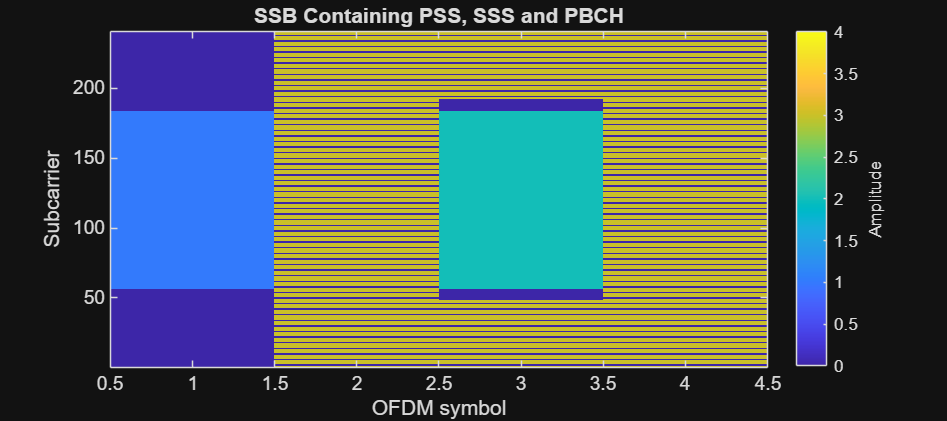

In [5]:
pbch = nrPBCH(codeword, cellID, v);   % PBCH sequence
pbch_indices = nrPBCHIndices(cellID); % PBCH indices
ssb(pbch_indices) = 3 * pbch;         % map the PBCH, scaled by beta=3 as per TS 38.211 Section 7.4.3.1.1

% plot the PBCH into SSB
figure('Position', [100 100 900 400])
imagesc(abs(ssb));
clim([0 4])
axis xy;
title('SSB Containing PSS, SSS and PBCH');
ylabel('Subcarrier');
xlabel('OFDM symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### **PBCH Demodulation Reference Signal (PBCH DM\-RS)**

DMRS is a 144\-symbol sequence (per SSB) that depends on the Cell ID and the time index part ${\bar{i} }_{SSB}$ (SSB index).


The UE shall assume the reference\-signal sequence $r(m)$ for an SSB is defined by


$$r(m)=\frac{1}{\sqrt{2}}\Bigl\lbrack \bigl(1-2\cdot c(2m)\bigr)+j\cdot \bigl(1-2\cdot c(2m+1)\bigr)\Bigr\rbrack$$

where $c(n)$ is the scrambling sequence.




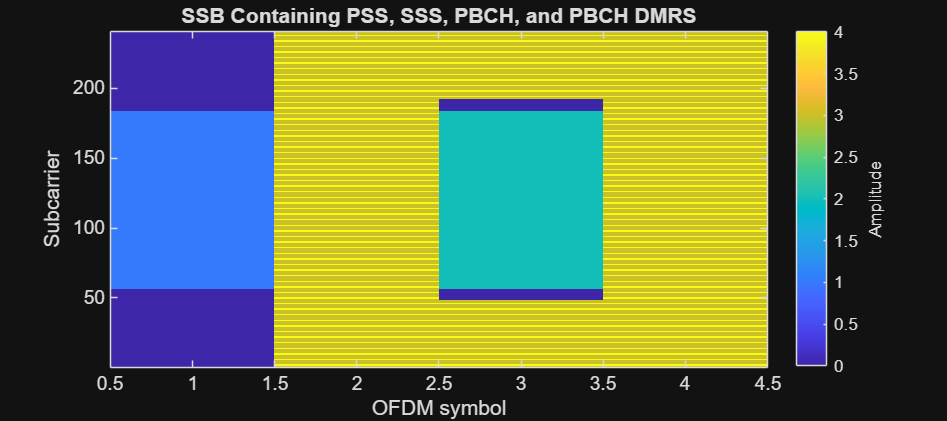

In [6]:
% consider ibar_ssb = 0

ibar_ssb = 0;                                  % initialize ibar_ssb
pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);      % generate DMRS
pbch_dmrs_indices = nrPBCHDMRSIndices(cellID); % get DMRS indices for PBCH
ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;        % map the PBCH DMRS into SSB, scaled by beta=4

% plot PBCH DMRS into SSB
figure('Position', [100 100 900 400])
imagesc(abs(ssb));
clim([0 4])
axis xy;
title('SSB Containing PSS, SSS, PBCH, and PBCH DMRS');
ylabel('Subcarrier');
xlabel('OFDM symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### SS Burst

An SS burst is composed of multiple SSBs and occupies half of a radio frame, which corresponds to five subframes.

#### Frame and Slot Structure (TS 38.211 §4.3.1)

One frame = 10 subframes (each of 1 ms).


One slot = 14 OFDM symbols (for normal CP).


The number of slots per subframe depends on the subcarrier spacing (SCS).

#### Subcarrier Spacing

Subcarrier spacing is defined by the numerology $\mu$


$$\textrm{SCS}=15\,\textrm{kHz}\cdot 2^{\mu }$$
#### Total Number of OFDM Symbols in an SS Burst

The number of OFDM symbols contained in an SS burst is:


$$N_{\textrm{symbols}} =\textrm{(symbols}\;\textrm{per}\;\textrm{slot)}\cdot 2^{\mu } \cdot N_{\textrm{subframes}}$$

$$N_{\textrm{symbols}} =\textrm{14}\cdot 2^{\mu } \cdot 5$$

For $\mu =1,$ $N_{\textrm{symbols}} =\textrm{140}$

#### SSB Pattern Inside the SS Burst

The maximum number of beams $L_{\max }$ depends on the operating band:


$$\textrm{Op.}\;\textrm{Band}\le 3\,\textrm{GHz}\;\;\Rightarrow \;\;L_{\max } =4\;\,$$

$$3\,\textrm{GHz}<\textrm{Op.}\;\textrm{Band}\le 6\,\textrm{GHz}\;\;\Rightarrow \;\;L_{\max } =8\;\,$$

$$\textrm{Op.}\;\textrm{Band}>6\,\textrm{GHz}\;\;\Rightarrow \;\;L_{\max } =64\;\,$$

Each beam transmits one SSB, and each beam is identified by an SS block index.


Block Patterns in FR1 (Sub\-6 GHz) \- Here, $L_{\max } =4\;\textrm{or}\;8$.

#### Case A – 15 KHz SCS

The first symbols of the candidate SS/PBCH blocks have indexes of $[2,8]+14*n$


For operation without shared spectrum channel access:

-  For carrier frequencies ≤ 3 GHz, $n=0,1$
-  For carrier frequencies within FR1 and > 3 GHz, $n=0,1,2,3$

For operation with shared spectrum channel access (as described in 3GPP TS 37.213):

-  $\displaystyle n=0,1,2,3,4$

Parameters $i_{SSB} \textrm{,}\;{\bar{i} }_{SSB}$, and $v$ are set up according to the rules in 3GPP TS 38.211 Sections 7.3.3.1 and 7.4.1.4.1


For $L_{\max } =4\textrm{,}\;{\bar{i} }_{SSB} =i_{SSB} +4n_{hf}$ where $n_{\textrm{hf}}$ is the number of the half\-frame in which the PBCH is transmitted in a frame, with $n_{\textrm{hf}} =0$ for the first half\-frame and $n_{\textrm{hf}} =1$ for the second half\-frame, and $i_{SSB}$ represents the two least significant bits of the candidate SS/PBCH block index as defined in 3GPP TS 38.213.


For $L_{\max } >4\textrm{,}\;{\bar{i} }_{SSB} =i_{SSB} \;\textrm{and}\;v=i_{SSB} \;\textrm{where}\;i_{SSB}$ is the three least significant bits of the candidate SS/PBCH block.


In [7]:
%{
*----- fc <= 3GHz -----*

Lmax  = 4
v     = 2 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 2 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1

%}

n_hf = 0;                   % Half-frame number
mu = 0;                     % mu = 0 → 15 kHz SCS
n_subframe = 5;             % total subframes in the SS burst
symbols_per_slot = 14;      % total OFDM symbols per slot
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_A1 = zeros([240 total_symbols]);

n = [0, 1];
first_symbol_index_ssb = [2; 8] + 14 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x4
     2     8    16    22


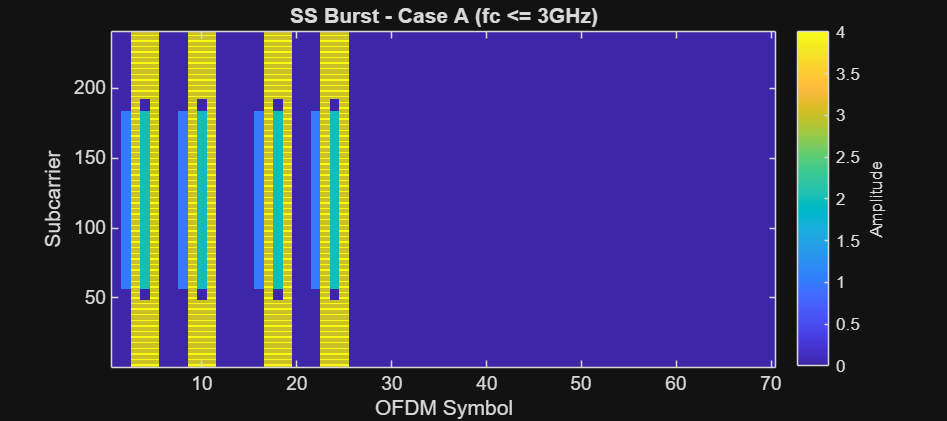

In [8]:

for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 4);
    issb = mod(ssb_index-1, 4);
    ibar_ssb = issb + 4 * n_hf;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_A1(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_A1));
clim([0 4])
axis xy;
title('SS Burst - Case A (fc <= 3GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

In [9]:
%{
*----- 3GHz < fc <= 6GHz -----*

Lmax  = 8
v     = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1, 2, 3

%}

mu = 0;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_A2 = zeros([240 total_symbols]);

n = [0, 1, 2, 3];
first_symbol_index_ssb = [2; 8] + 14 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x8
     2     8    16    22    30    36    44    50


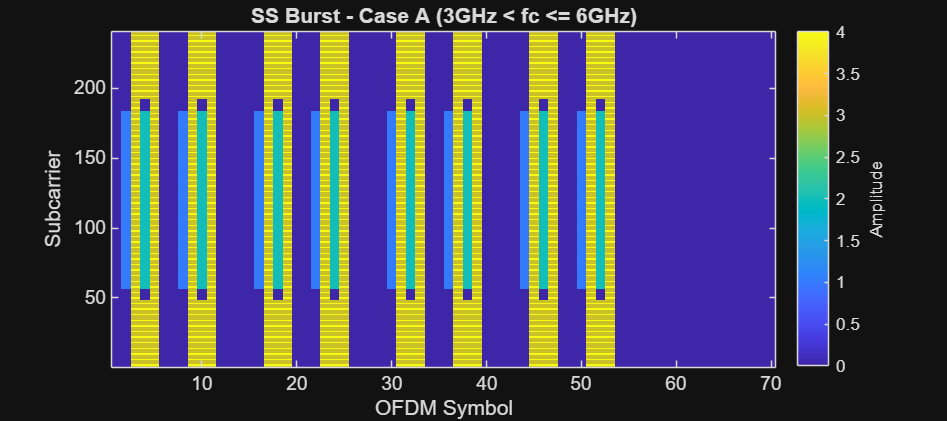

In [10]:

for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 8);
    issb = v;
    ibar_ssb = issb;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_A2(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_A2));
clim([0 4])
axis xy;
title('SS Burst - Case A (3GHz < fc <= 6GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Case B – 30 KHz SCS

The first symbols of the candidate SS/PBCH blocks have indexes of $[4,8,16,20]+28*n$

-  For carrier frequencies ≤ 3 GHz, $n=0$
-  For carrier frequencies within FR1 and > 3 GHz, $n=0,1$

In [11]:
%{
*----- fc <= 3GHz -----*

Lmax  = 4
v     = 2 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 2 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0

%}

n_hf = 0;
mu = 1;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_B1 = zeros([240 total_symbols]);

n = 0;
first_symbol_index_ssb = [4; 8; 16; 20] + 28 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x4
     4     8    16    20


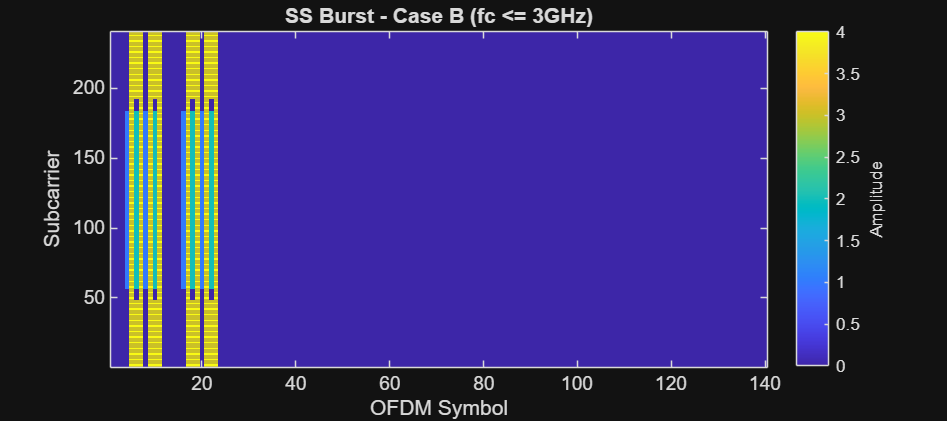

In [12]:

for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 4);
    issb = mod(ssb_index-1, 4);
    ibar_ssb = issb + 4 * n_hf;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_B1(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_B1));
clim([0 4])
axis xy;
title('SS Burst - Case B (fc <= 3GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

In [13]:
%{
*----- 3MHz < fc <= 6GHz -----*

Lmax  = 8
v     = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1

%}

mu = 1;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_B2 = zeros([240 total_symbols]);

n = [0, 1];
first_symbol_index_ssb = [4; 8; 16; 20] + 28 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x8
     4     8    16    20    32    36    44    48


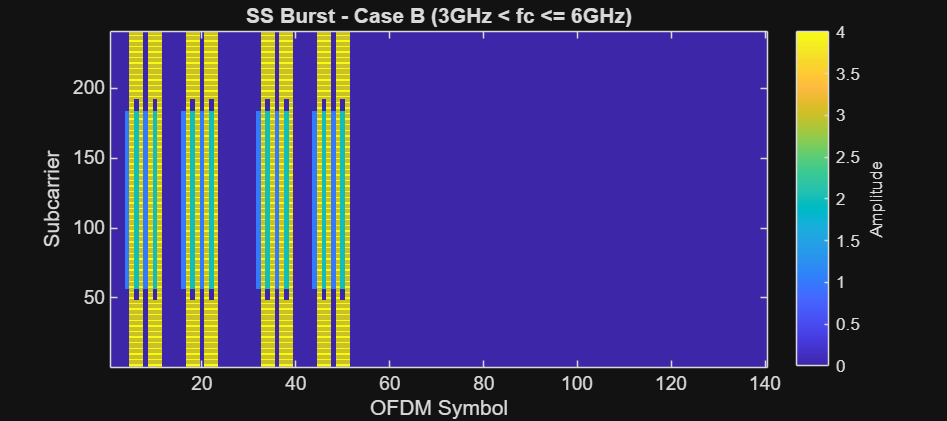

In [14]:

for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 8);
    issb = v;
    ibar_ssb = issb;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_B2(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_B2));
clim([0 4])
axis xy;
title('SS Burst - Case B (3GHz < fc <= 6GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Case C \- 30 KHz SCS

The first symbols of the candidate SS/PBCH blocks have indexes: $[2,8]+14*n$


Operation without shared spectrum channel access


Paired spectrum operation:

-  For carrier frequencies ≤ 3 GHz → $n=0,1$
-  For carrier frequencies within FR1 and > 3 GHz → $n=0,1,2,3$

Unpaired spectrum operation:

-  For carrier frequencies < 1.88 GHz → $n=0,1\;$
-  For carrier frequencies within FR1 and ≥ 1.88 GHz → $n=0,1,2,3$

Operation with shared spectrum channel access:

-  $\displaystyle n=0,1,2,3,4,5,6,7,8,9$

In [15]:
%{
*----- fc <= 3GHz -----*

Lmax  = 4
v     = 2 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 2 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1

%}

n_hf = 0;
mu = 1;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_C1 = zeros([240 total_symbols]);

n = [0, 1];
first_symbol_index_ssb = [2; 8;] + 14 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x4
     2     8    16    22


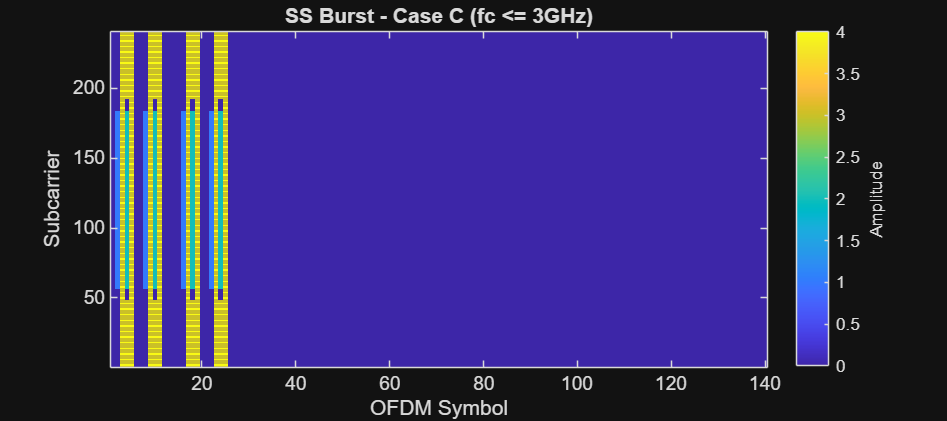

In [16]:

for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 4);
    issb = mod(ssb_index-1, 4);
    ibar_ssb = issb + 4 * n_hf;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_C1(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_C1));
clim([0 4])
axis xy;
title('SS Burst - Case C (fc <= 3GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

In [17]:
%{
*----- 3MHz < fc <= 6GHz -----*

Lmax  = 8
v     = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1, 2, 3

%}

mu = 1;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_C2 = zeros([240 total_symbols]);

n = [0, 1, 2, 3];
first_symbol_index_ssb = [2; 8;] + 14 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x8
     2     8    16    22    30    36    44    50


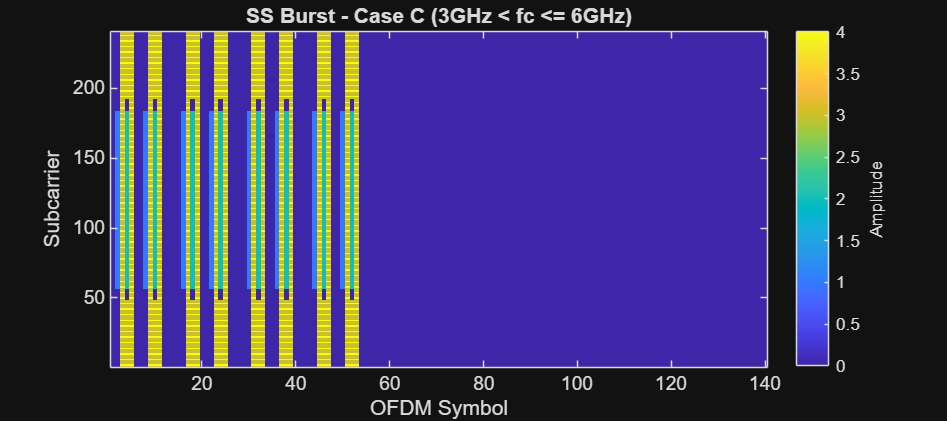

In [18]:

for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 8);
    issb = v;
    ibar_ssb = issb;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_C2(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_C2));
clim([0 4])
axis xy;
title('SS Burst - Case C (3GHz < fc <= 6GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Case D \- 120 KHz SCS

The first symbols of the candidate SS/PBCH blocks have indexes: $[4,8,16,20]+28*n$


For carrier frequencies within FR2, $n=0,1,2,3,5,6,7,8,10,11,12,13,15,16,17,18$


In [19]:
%{
*----- fc > 6GHz -----*

Lmax  = 64
v     = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18

%}

mu = 3;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_D = zeros([240 total_symbols]);

n = [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18];
first_symbol_index_ssb = [4; 8; 16; 20;] + 28 * n;
disp(first_symbol_index_ssb);

     4    32    60    88   144   172   200   228   284   312   340   368   424   452   480   508
     8    36    64    92   148   176   204   232   288   316   344   372   428   456   484   512
    16    44    72   100   156   184   212   240   296   324   352   380   436   464   492   520
    20    48    76   104   160   188   216   244   300   328   356   384   440   468   496   524


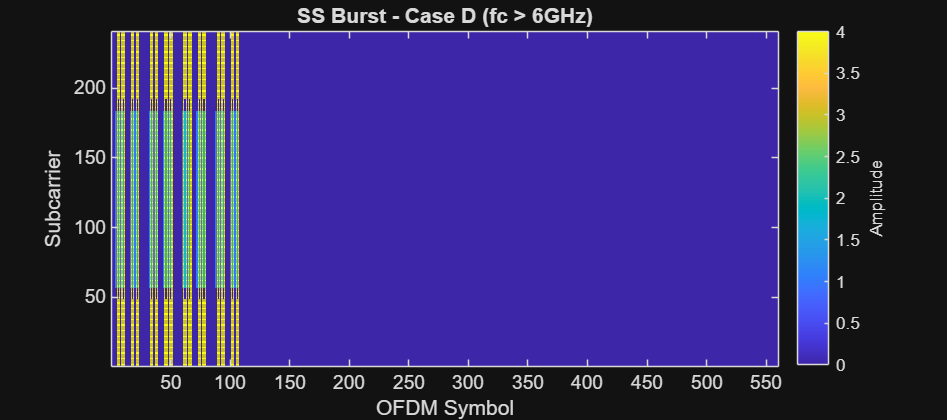

In [20]:

for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 8);
    issb = v;
    ibar_ssb = issb;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_D(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_D));
clim([0 4])
axis xy;
title('SS Burst - Case D (fc > 6GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Case E \- 240 KHz SCS

The first symbols of the candidate SS/PBCH blocks have indexes: $[8,12,16,20,32,36,40,44]+56*n$


For carrier frequencies within FR2\-1, $n=0,1,2,3,5,6,7,8$


In [21]:
%{
*----- fc > 6GHz -----*

Lmax  = 64
v     = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1, 2, 3

%}

mu = 4;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_E = zeros([240 total_symbols]);

n = [0, 1, 2, 3, 5, 6, 7, 8];
first_symbol_index_ssb = [8; 12; 16; 20; 32; 36; 40; 44;] + 14 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x64
     8    12    16    20    32    36    40    44    22    26    30    34    46    50    54    58    36    40    44    48    60    64    68    72    50    54    58    62    74    78    82    86    78    82    86    90   102   106   110   114    92    96   100   104   116   120   124   128   106   110


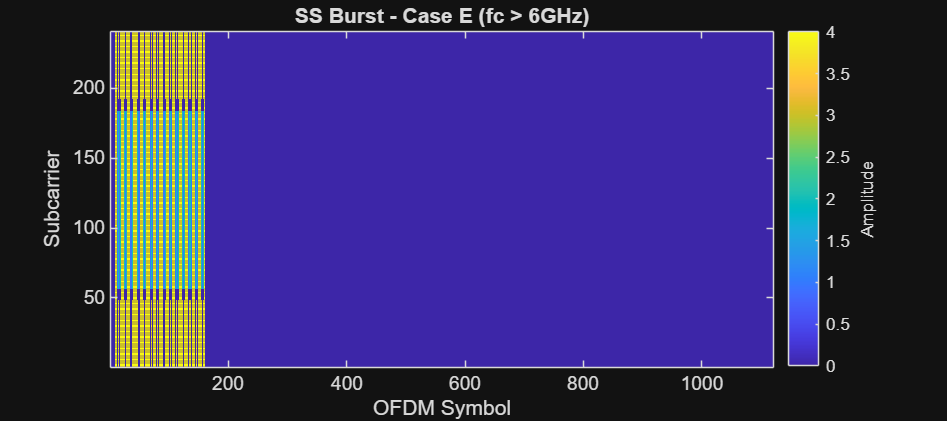

In [22]:
for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 8);
    issb = v;
    ibar_ssb = issb;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_E(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_E));
clim([0 4])
axis xy;
title('SS Burst - Case E (fc > 6GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Case F \- 480 KHz SCS

The first symbols of the candidate SS/PBCH blocks have indexes: $[2,9]+14*n$


For carrier frequencies within FR2\-2,       $n=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31$


In [23]:
%{
*----- fc > 6GHz -----*

Lmax  = 64
v     = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

%}

mu = 5;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_F = zeros([240 total_symbols]);

n = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31];
first_symbol_index_ssb = [2; 9;] + 14 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x64
     2     9    16    23    30    37    44    51    58    65    72    79    86    93   100   107   114   121   128   135   142   149   156   163   170   177   184   191   198   205   212   219   226   233   240   247   254   261   268   275   282   289   296   303   310   317   324   331   338   345


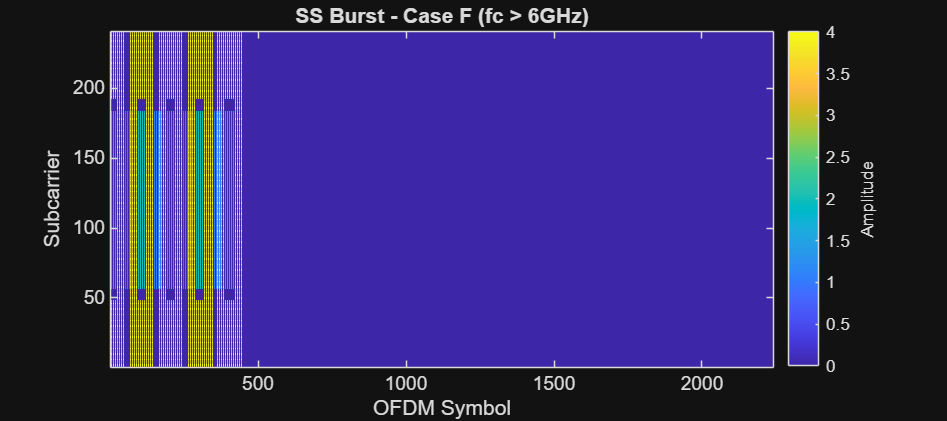

In [24]:
for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 8);
    issb = v;
    ibar_ssb = issb;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_F(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_F));
clim([0 4])
axis xy;
title('SS Burst - Case F (fc > 6GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Case G \- 960 KHz SCS

The first symbols of the candidate SS/PBCH blocks have indexes: $[2,9]+14*n$


For carrier frequencies within FR2\-2, $n=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31$


In [25]:
%{
*----- fc > 6GHz -----*

Lmax  = 64
v     = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.3.3.1)
i_ssb = 3 LSBs of candidate SS/PBCH block index (TS 38.211 §7.4.1.4.1)
n_hf  = 0 as all SSBs are in the first half-frame
n     = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

%}

mu = 6;
n_subframe = 5;
symbols_per_slot = 14;
total_symbols = symbols_per_slot * 2^mu * n_subframe;
ss_burst_G = zeros([240 total_symbols]);

n = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31];
first_symbol_index_ssb = [2; 9;] + 14 * n;
first_symbol_index_ssb = first_symbol_index_ssb(:).'

first_symbol_index_ssb = 1x64
     2     9    16    23    30    37    44    51    58    65    72    79    86    93   100   107   114   121   128   135   142   149   156   163   170   177   184   191   198   205   212   219   226   233   240   247   254   261   268   275   282   289   296   303   310   317   324   331   338   345


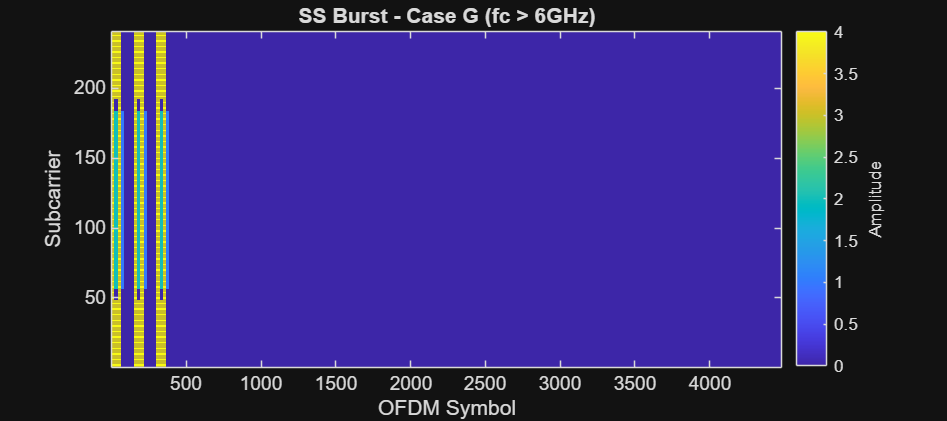

In [26]:

for ssb_index = 1:length(first_symbol_index_ssb)
    v = mod(ssb_index-1, 8);
    issb = v;
    ibar_ssb = issb;

    pbch = nrPBCH(codeword, cellID, v);
    ssb(pbch_indices) = 3 * pbch;

    pbch_dmrs = nrPBCHDMRS(cellID, ibar_ssb);
    ssb(pbch_dmrs_indices) = 4 * pbch_dmrs;

    ss_burst_G(:, first_symbol_index_ssb(ssb_index) + (0:3)) = ssb;
end

% plot the SS burst
figure('Position', [100 100 900 400])
imagesc(abs(ss_burst_G));
clim([0 4])
axis xy;
title('SS Burst - Case G (fc > 6GHz)');
ylabel('Subcarrier');
xlabel('OFDM Symbol');

c = colorbar;
c.Label.String = 'Amplitude';

#### Generate signal containing SS burst and SIB1
-  Define a structure named config to store all transmission parameters.
-  Set the cell identity cellID to uniquely identify the 5G cell.
-  Choose the SS Burst pattern BlockPattern based on the frequency range (Case A, B, C for FR1; Case D, E for FR2).
-  Specify the number of transmitted SSBs using TransmittedBlocks (e.g., ones(1,8) for eight SSBs).
-  Set the subcarrier spacing SubcarrierSpacingCommon for SIB1 (15 or 30 kHz for FR1).
-  Enable or disable SIB1 transmission using EnableSIB1 (1 means enabled).
-  Set the minimum channel bandwidth MinChannelBW (e.g., 5 MHz).
-  Apply a power boost using boost to simulate beamforming (e.g., 6 dB boost for the first SSB).
-  Prepare the waveform configuration using hSIB1WaveformConfiguration(config).
-  Generate the waveform using nrWaveformGenerator(wavegenConfig).
-  Obtain txWaveform (transmitted samples) and waveInfo (waveform details).


In [27]:

% Configure the cell identity
config = struct();
config.NCellID = 10;  % cell ID

% Configure the SS burst parameters for fc > 3GHz so Lmax = 8
config.BlockPattern = 'Case A';         % FR1 options: 'Case A','Case B','Case C'
config.TransmittedBlocks = ones(1,8);   % Bitmap for 8 transmitted SSBs
config.SubcarrierSpacingCommon = 15;    % SIB1 subcarrier spacing in kHz (15 or 30 for FR1)
config.EnableSIB1 = 1;                  % Enable SIB1
config.MinChannelBW = 5;                % Minimum channel bandwidth (MHz)

% Introduce beamforming gain (boost one SSB)
boost = 6;                              % Power boost in dB
config.Power = zeros(size(config.TransmittedBlocks));
config.Power(1) = boost;                % Boost the first SSB

% Configure and generate a waveform containing an SS burst and SIB1
waveform_config = hSIB1WaveformConfiguration(config);
[tx_waveform, wave_info] = nrWaveformGenerator(waveform_config);
tx_OFDM_info = wave_info.ResourceGrids(1).Info;


### B. Wireless Channel (AWGN)
-  The signal is passed through a wireless channel with Additive White Gaussian Noise (AWGN).
-  $r[n]=x[n]+w[n],$ where $r[n]=$ received signal, $x[n]=$ transmitted signal, $w[n]=$ random noise with Gaussian distribution.

In [28]:
% Add white Gaussian noise to simulate realistic conditions

rng('default');                         % Reset random number generator
SNRdB = 20;                             % Desired SNR in dB
rx_waveform = awgn(tx_waveform, SNRdB - boost, -10*log10(double(tx_OFDM_info.Nfft)));


### C. Receiver Side


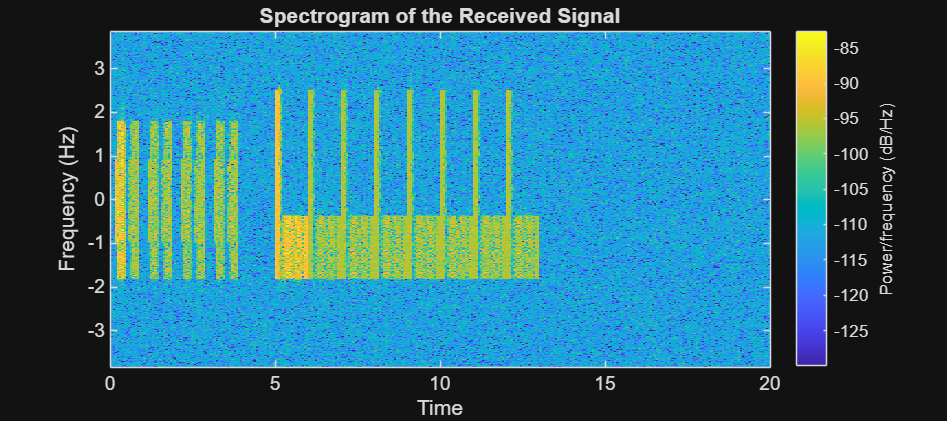

In [29]:

% Receiver parameters
sample_rate = tx_OFDM_info.SampleRate;    % Sample rate in samples/second
f_phase_comp = 0;                         % No phase compensation
min_channel_BW = config.MinChannelBW;     % Minimum channel bandwidth (MHz)

% Configure burst parameters at receiver
ref_burst.BlockPattern = config.BlockPattern;
ref_burst.L_max = numel(config.TransmittedBlocks);

% Get OFDM information from the SS burst configuration
nr_SSB = 20;                            % Number of resource blocks in SSB
scs_SSB = hSSBurstSubcarrierSpacing(ref_burst.BlockPattern);
rx_OFDM_info = nrOFDMInfo(nr_SSB, scs_SSB, 'SampleRate', sample_rate);

% Display spectrogram of the received signal
figure('Position', [100 100 900 400])
nfft = rx_OFDM_info.Nfft;
spectrogram(rx_waveform(:,1), ones(nfft,1), 0, nfft, 'centered', sample_rate, 'yaxis', 'MinThreshold', -130);
title('Spectrogram of the Received Signal');
xlabel('Time');
ylabel('Frequency (Hz)');

#### PSS Search and Frequency Offset Correction
-  The receiver first tries a set of possible frequency offsets (shifts) and checks which one makes the PSS pattern line up best with the received signal.
-  The best match tells us three things: (A) the coarse frequency offset, (B) which PSS (NID2 = 0,1,2) was transmitted, and (C) when (time) the PSS occurs.
-  After coarse correction, the receiver refines the frequency offset using the cyclic prefix (CP) of OFDM symbols — the phase of a CP\-based correlation gives a fine frequency estimate.

a. Received signal is multiplied by a rotating phasor:


$$r[n]=s[n]\cdot e^{j2\pi \Delta fnT_s }$$

where

-  $s[n]$ is the transmitted signal
-  $\Delta f$ is the unknown frequency offset (Hz)
-  $Ts=1/fs$ is the sampling period

b. Try many candidate offsets $f_{cand}$ inside a search window (`searchBW`). Candidates are spaced half a subcarrier apart:


$$\textrm{step}=\frac{\Delta f_{sc} }{2}$$

where $\Delta f_{sc}$ is subcarrier spacing. For each candidate $f_{\textrm{cand}}$ we form a frequency\-shifted version of the received signal:


$$r_{\textrm{shift}} [n;f_{\textrm{cand}} ]=r[n]\cdot e^{-j2\pi f_{\textrm{cand}} nT_s }$$

This removes the any trial offset from the received signal.


c. Correlate with PSS \- For each candidate shift and each possible PSS, compute the cross\-correlation:


$$C(f_{\textrm{cand}} ,NID2,\tau )=\sum_{m=0}^{L-1} r_{\textrm{shift}} [m+\tau ;f_{\textrm{cand}} ]\cdot p_{NID2}^* [m]$$

where

-  L is the length of the PSS
-  $\tau$ is a time offset (search position)

The correlation magnitude $|C|$ measures how well the trial\-shifted received signal matches with PSS at time $\tau$.


d. Find the values $(f^{\textrm{cand}} ,N_{\textrm{ID2}} ,\tau )$ which maximizes the funtion:


$$(f^{\textrm{cand}} ,N_{\textrm{ID2}} ,\tau )=\arg \max_{f_{\textrm{cand}} ,N_{\textrm{ID2}} ,\tau } |C(f_{\textrm{cand}} ,N_{\textrm{ID2}} ,\tau )|$$

where

-  ${\hat{f} }$ is the coarse frequency offset estimate
-  ${\hat{N} }_{ID2}$ gives part of the cell ID
-  $\hat{\tau}$ gives the time instant of the strongest SSB

e. Correct the received signal by removing that offset:


$$r_{\textrm{corr}} [n]=r[n]\cdot e^{-j2\pi \hat{f} nT_s }$$

Now the new waveform rx\_wave is frequency\-aligned.



In [30]:
disp(' Frequency correction and timing estimation ')

 Frequency correction and timing estimation


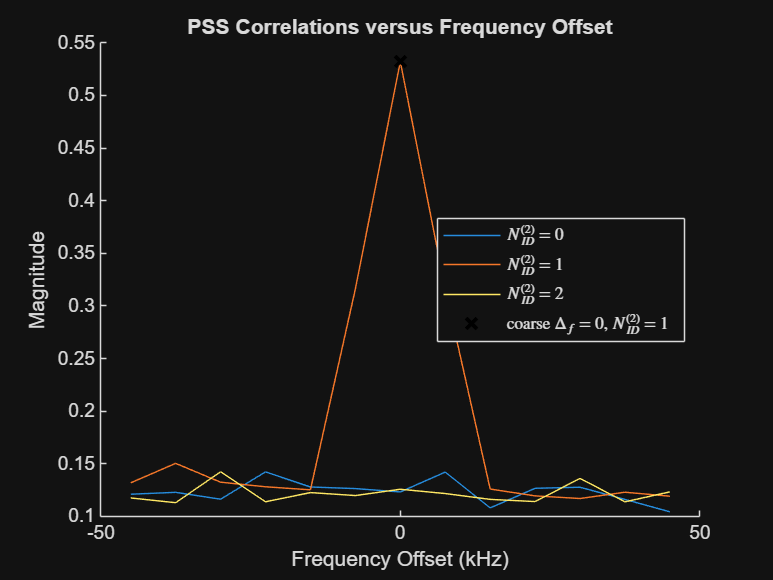

In [31]:

% Specify the frequency offset search bandwidth in kHz
figure('Position', [100 100 900 400])
search_BW = 6*scs_SSB;
[rx_wave, freq_offset, NID2] = hSSBurstFrequencyCorrect(rx_waveform, ref_burst.BlockPattern, sample_rate, search_BW);

In [32]:
disp([' Frequency offset: ' num2str(freq_offset,'%.0f') ' Hz'])

 Frequency offset: -59 Hz


#### Time Synchronization and OFDM Demodulation

After detecting the PSS and correcting the frequency offset, the receiver now knows which PSS sequence was transmitted ( $N_{ID}^2$ ) and approximately when the SSB starts in time.


To accurately extract the SSB, the receiver must find the exact symbol boundary \- this process is called time synchronization.


Create a Reference Grid for PSS and  put the PSS sequenc in 2nd symbol. Slide this reference grid over the received waveform (rx\_wave) and computes cross\-correlation between the known PSS sequence and the received samples.


$$R_{rs} [\tau ]=\sum_n r[n]\cdot s^* [n-\tau ]$$

where

-  $r[n]$ is received time\-domain waveform
-  $s[n]$ reference PSS signal (generated locally)

The estimated timing offset is the value of $\tau$ that maximizes correlation:


$$\hat{\tau} =\arg \max_{\tau } |R_{rs} [\tau ]|$$

The receiver now discards the samples before the estimated start of the SSB. It performs OFDM demodulation to convert the time\-domain waveform into the frequency domain grid.


$$X[k]=\sum_{n=0}^{N_{FFT} -1} x[n]e^{-j2\pi \frac{kn}{N_{FFT} }}$$

After demodulation, we extract symbols 2 to 5 since they carry:

-  PSS (symbol 2)
-  SSS (symbol 4)
-  PBCH and PBCH DMRS (symbols 3–5)

In [33]:
% 1: Create a reference grid using the detected PSS

% Each SS Block (SSB) spans 240 subcarriers (20 RBs * 12 subcarriers)
% and 4 OFDM symbols. We use only 2 symbols here to estimate timing.
ref_grid = zeros([nr_SSB*12 2]);  % Create an empty grid (frequency x symbols)

% Place the detected PSS sequence (based on NID2) in the 2nd OFDM symbol.
% This avoids issues with the special CP (Cyclic Prefix) length in the 1st symbol.
ref_grid(nrPSSIndices, 2) = nrPSS(NID2);

% 2: Estimate the timing offset

% nSlot = 0 means we're processing the first slot.
n_slot = 0;

% Estimate where the received waveform aligns with the start of the SS Block.
% 'timingOffset' gives the number of samples from the beginning of rxWave
% to the start of the detected SSB.
timing_offset = nrTimingEstimate(rx_waveform, nr_SSB, scs_SSB, n_slot, ref_grid, 'SampleRate', sample_rate);

% 3: Synchronize, OFDM-demodulate, and extract the SS Block

% Remove samples before the detected SSB start (synchronization).
% Then, perform OFDM demodulation to get the frequency-domain grid.
rx_grid = nrOFDMDemodulate(rx_waveform(1 + timing_offset:end, :), nr_SSB, scs_SSB, n_slot, 'SampleRate', sample_rate);

% Extract symbols 2 to 5 which contain PSS, SSS, PBCH, and PBCH DMRS.
rx_grid = rx_grid(:, 2:5, :);

% 4: Display timing offset information

% Adjust symbol length to account for receiver sample rate difference.
sr_ratio = sample_rate / (scs_SSB * 1e3 * rx_OFDM_info.Nfft);
first_symbol_length = rx_OFDM_info.SymbolLengths(1) * sr_ratio;

% Display timing offset in both samples and milliseconds.
% This shows how far into the received waveform the SS Block starts.
msg = sprintf(' Time offset to synchronization block: %%.0f samples (%%.%.0ff ms) \n', floor(log10(sample_rate)) - 3);
fprintf(msg, timing_offset + first_symbol_length, (timing_offset + first_symbol_length) / sample_rate * 1e3);

 Time offset to synchronization block: 1100 samples (0.143 ms)


#### SSS Search

After PSS detection and time synchronization, the receiver must determine the full cell identity (cellID). The receiver already knows $N_{ID}^2$ from PSS detection, so it now determines $N_{ID}^1$ by correlating the received signal with all 336 possible reference SSS sequences.


The correlation is computed as:


$$C(N_{ID}^2 )=\left|\sum_{n=0}^{126} r_{SSS} (n)\cdot {\left(s_{SSS(N_{ID}^2 )}^* (n)\right)}^2 \right|$$

-  $r_{SSS} (n)$ is the received SSS sequence
-  $s_{SSS(N_{ID}^2 )}^* (n)$ is the complex conjugate of the SSS sequence

The strongest peak in correlation indicates the correct $N_{ID}^1$. Complete cell ID is calculated as:


$${\textrm{cellID}}_{\textrm{extracted}} =(3\times N_{ID}^1 )+N_{ID}^2$$



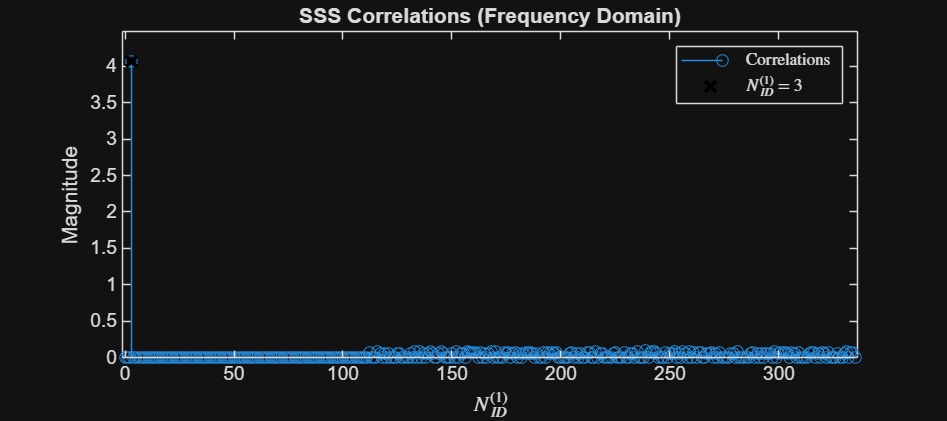

In [34]:
%% 1: Create a reference grid using the detected PSS

% Each SS Block (SSB) spans 240 subcarriers (20 RBs * 12 subcarriers)
% and 4 OFDM symbols. We use only 2 symbols here to estimate timing.
ref_grid = zeros([nr_SSB*12 2]);  % Empty grid (frequency x symbols)

% Place the detected PSS sequence (based on NID2) in the 2nd OFDM symbol.
% This avoids issues with the special CP (Cyclic Prefix) length in the 1st symbol.
ref_grid(nrPSSIndices, 2) = nrPSS(NID2);

%% 2: Estimate the timing offset

% n_slot = 0 means processing the first slot.
n_slot = 0;

% Estimate where the received waveform aligns with the start of the SS Block.
% 'timing_offset' gives the number of samples from the start of rx_waveform
% to the detected SSB.
timing_offset = nrTimingEstimate(rx_waveform, nr_SSB, scs_SSB, n_slot, ref_grid, 'SampleRate', sample_rate);

%% 3: Synchronize, OFDM-demodulate, and extract the SS Block

% Remove samples before the detected SSB start (synchronization)
rx_grid = nrOFDMDemodulate(rx_waveform(1 + timing_offset:end, :), nr_SSB, scs_SSB, n_slot, 'SampleRate', sample_rate);

% Extract symbols 2 to 5 which contain PSS, SSS, PBCH, and PBCH DMRS
rx_grid = rx_grid(:, 2:5, :);

%% 4: Extract the received SSS symbols

% Use the SSS indices to extract received SSS symbols from the demodulated grid
sss_indices = nrSSSIndices;
sss_rx = nrExtractResources(sss_indices, rx_grid);

%% 5: Correlate received SSS with all possible sequences to estimate NID1

sss_est = zeros(1, 336);  % Pre-allocate correlation vector
for NID1_candidate = 0:335
    % Form candidate cell ID using NID1 and known NID2
    ncellid_candidate = (3 * NID1_candidate) + NID2;

    % Generate reference SSS sequence
    sss_ref = nrSSS(ncellid_candidate);

    % Correlate received SSS with reference SSS (frequency domain)
    sss_est(NID1_candidate + 1) = sum(abs(mean(sss_rx .* conj(sss_ref), 1)).^2);
end

%% 6: Plot SSS correlations

figure('Position', [100 100 900 400])
stem(0:335, sss_est, 'o');
title('SSS Correlations (Frequency Domain)');
xlabel('$N_{ID}^{(1)}$', 'Interpreter', 'latex');
ylabel('Magnitude');
axis([-1 336 0 max(sss_est)*1.1]);

% Identify NID1 as the index with the strongest correlation
NID1 = find(sss_est == max(sss_est)) - 1;

% Mark the estimated NID1 on the plot
hold on;
plot(NID1, max(sss_est), 'kx', 'LineWidth', 2, 'MarkerSize', 8);
legend(["Correlations" "$N_{ID}^{(1)}$ = " + num2str(NID1)], 'Interpreter', 'latex');

In [35]:

%% 7: Form overall cell identity

% Combine estimated NID1 and known NID2
cellID_extracted = (3 * NID1) + NID2;

% Display the detected cell identity
disp(['Cell ID: ' num2str(cellID_extracted)]);

Cell ID: 10


#### PBCH DM\-RS search

The receiver tests each possible PBCH DM\-RS pattern (there are 8 possibilities for `ibar_SSB` = 0..7), uses those DM\-RS symbols to estimate the channel and the noise, computes an SNR estimate for each candidate, and selects the candidate with the highest SNR.


The chosen `ibar_SSB` gives the least significant bits of the SS/PBCH block index and is used later for PBCH descrambling and decoding.

-  Generate all possible PBCH DM\-RS sequences.
-  For each candidate PBCH DM\-RS, estimate the channel response and noise level.
-  Determine the signal\-to\-noise ratio for each PBCH DM\-RS candidate.
-  Select the PBCH DM\-RS with the highest SNR.
-  Use the index of the selected PBCH DM\-RS to obtain the least significant bits (LSBs) of the SS/PBCH block index.
-  Initialize PBCH scrambling using the derived SS/PBCH block index.

SNR estimate for that DM\-RS candidate is calculated as:


$$\textrm{dmrsEst}=10\log_{10} \left(\frac{\mathrm{mean}\left(|h_{\textrm{est}} |^2 \right)}{n_{est} }\right)$$

Pick the ${\bar{i} }_{\textrm{SSB}}$ index that gave the highest estimated SNR.


That index is assumed to be the correct PBCH DM\-RS pattern index.



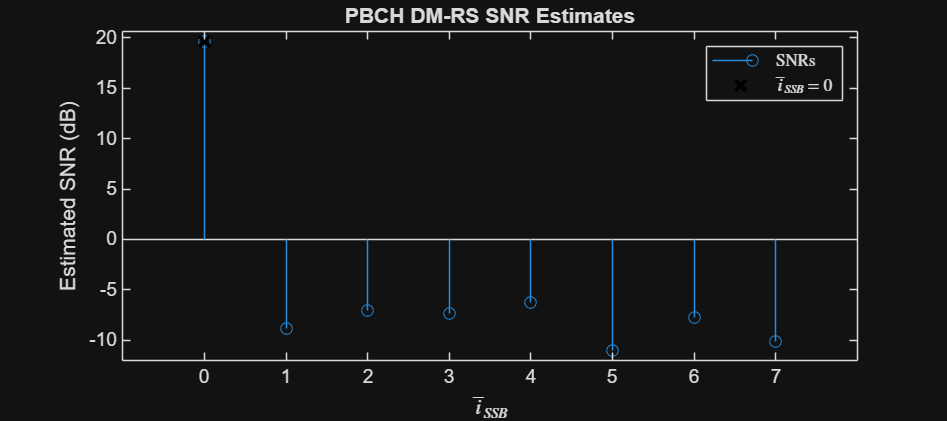

In [36]:
%% 1: Calculate PBCH DM-RS indices

% Get the PBCH DM-RS resource element indices for the detected cell
dmrs_indices = nrPBCHDMRSIndices(cellID_extracted);

%% 2: Channel estimation and SNR calculation for each PBCH DM-RS candidate

dmrs_est = zeros(1, 8);  % Pre-allocate vector for SNR estimates
for ibar_SSB_candidate = 0:7
    % Create reference grid for the current DM-RS candidate
    ref_grid = zeros([240 4]);
    ref_grid(dmrs_indices) = nrPBCHDMRS(cellID_extracted, ibar_SSB_candidate);

    % Estimate channel (hest) and noise (nest) using the DM-RS
    [h_est, n_est] = nrChannelEstimate(rx_grid, ref_grid, 'AveragingWindow', [0 1]);

    % Calculate SNR in dB for the candidate
    dmrs_est(ibar_SSB_candidate + 1) = 10*log10(mean(abs(h_est(:).^2)) / n_est);
end

%% 3: Plot PBCH DM-RS SNR estimates

figure('Position', [100 100 900 400])
stem(0:7, dmrs_est, 'o');
title('PBCH DM-RS SNR Estimates');
xlabel('$\overline{i}_{SSB}$', 'Interpreter', 'latex');
xticks(0:7);
ylabel('Estimated SNR (dB)');
axis([-1 8 min(dmrs_est)-1 max(dmrs_est)+1]);

%% 4: Determine ibar_SSB with the highest SNR

ibar_SSB = find(dmrs_est == max(dmrs_est)) - 1;

% Mark the selected ibar_SSB on the plot
hold on;
plot(ibar_SSB, max(dmrs_est), 'kx', 'LineWidth', 2, 'MarkerSize', 8);
legend(["SNRs" "$\overline{i}_{SSB}$ = " + num2str(ibar_SSB)], 'Interpreter', 'latex');

#### Channel Estimation using PBCH DM\-RS and SSS
-  Create a reference grid for the SSB (frequency × symbols).
-  Insert PBCH DM\-RS symbols using the detected ${\bar{i} }_{\textrm{SSB}}$.
-  Insert SSS symbols using the detected ncellid.
-  Perform channel estimation over the combined reference symbols.
-  Obtain the estimated channel (hest), noise variance (nVar), and additional info (hestInfo).

In reference grid, two known sequences are inserted:

-  PBCH DM\-RS: Pilot tones embedded in PBCH for channel estimation.
-  SSS: it helps refine channel estimation because it spans frequency
#### Estimate channel at pilot positions

At every position $(k,n)$ where a reference symbol $s_{\textrm{ref}} (k,n)$ exists, we can directly estimate the channel:


$$\hat{h} (k,n)=\frac{s_{\textrm{ref}} (k,n)}{y(k,n)}$$

where

-  $y(k,n)$ = received complex symbol at subcarrier k, symbol n
-  $s_{\textrm{ref}} (k,n)$ = known transmitted pilot (from DM\-RS or SSS)

This gives channel samples at those pilot locations.


The channel is not only needed at pilot positions, we need it for every resource element (RE) in the SSB to equalize PBCH later. Hence interpolate $\hat{h} (k,n)$ across frequency and time.


The function AveragingWindow smooths over neighboring symbols (time averaging window of 1) to make the estimate less noisy.


Estimate the noise variance ${\hat{\sigma} }_n^2$ and it is derived from how much the received pilot symbols deviate from the expected ones:


$${\hat{\sigma} }_n^2 =\frac{1}{M}\sum_{(k,n)\in I_{\textrm{ref}} } {\left|y(k,n)-{\hat{h} }^{(k,n)} s_{\textrm{ref}} (k,n)\right|}^2$$

If the received symbol perfectly matches the expected pilot, then its low noise variance and if it fluctuates it shows higher noise variance.


In [37]:
%% 1: Create reference grid using PBCH DM-RS and SSS

% Each SS/PBCH block spans 'nrbSSB' RBs (12 subcarriers each) and 4 OFDM symbols
ref_grid = zeros([nr_SSB*12 4]);

% Place PBCH DM-RS symbols corresponding to the detected ibar_SSB
ref_grid(dmrs_indices) = nrPBCHDMRS(cellID_extracted, ibar_SSB);

% Place SSS symbols corresponding to the detected NID1/NID2
ref_grid(sss_indices) = nrSSS(cellID_extracted);

%% 2: Estimate the channel and noise

% Perform channel estimation using the combined reference symbols (PBCH DM-RS + SSS)
% 'hest' contains the estimated channel response
% 'nVar' is the estimated additive noise variance
% 'hestInfo' contains additional info about the estimation
[h_est, n_var, h_est_info] = nrChannelEstimate(rx_grid, ref_grid, 'AveragingWindow', [0 1]);


#### PBCH demodulation and BCH decoding
-  Extract PBCH symbols from the received SS/PBCH grid.
-  Determine PBCH scrambling parameter v based on ibar\_SSB and L\_max.
-  Extract the estimated channel for PBCH resource elements.
-  Perform MMSE equalization using the channel estimate and noise variance.
-  Plot the equalized PBCH constellation for visualization.
-  Demodulate and decode the PBCH to obtain bit estimates.
-  Calculate and display the RMS PBCH EVM to evaluate demodulation quality.

We have now Cell ID (cellID), channel estimate (h\_est), noise estimate (n\_var) and frequency and timing corrections applied. The receiver can finally demodulate the PBCH and recover the BCH bits, which carry the MIB. The first actual data a UE decodes in a 5G cell.


Extract the PBCH from the received OFDM grid, then with the help of PBCH indices and Lmax detemine the v.


$$v=\textrm{LSBs}\;\textrm{of}\;{\bar{i} }_{\textrm{SSB}}$$

where ${\bar{i} }_{SSB} \in [0,L_{\max } -1]$. This ensures that PBCH sequences transmitted in different SSBs use slightly different scrambling patterns.


The received PBCH symbols $y$ are distorted by the channel $h$ and noise $n$: $y=h\cdot x+n$


To recover $x$, we need to undo the effect of $h$. The Minimum Mean Square Error (MMSE) equalizer is given by:


$$\hat{x} =\frac{h^* }{|h|^2 +\sigma_n^2 }y$$

where:

-  $h^*$ = complex conjugate of h
-  $\sigma_n^2$ � = noise variance
-  $\hat{x}$ = equalized (recovered) symbol

This method provides a balance between noise amplification and channel inversion (unlike zero\-forcing).


CSI (output of nrEqualizeMMSE) gives per\-symbol reliability, how strong/clean the signal was after equalization.


In [38]:
%% PBCH Demodulation and BCH Decoding

disp(' -- PBCH demodulation and BCH decoding -- ');

 -- PBCH demodulation and BCH decoding --


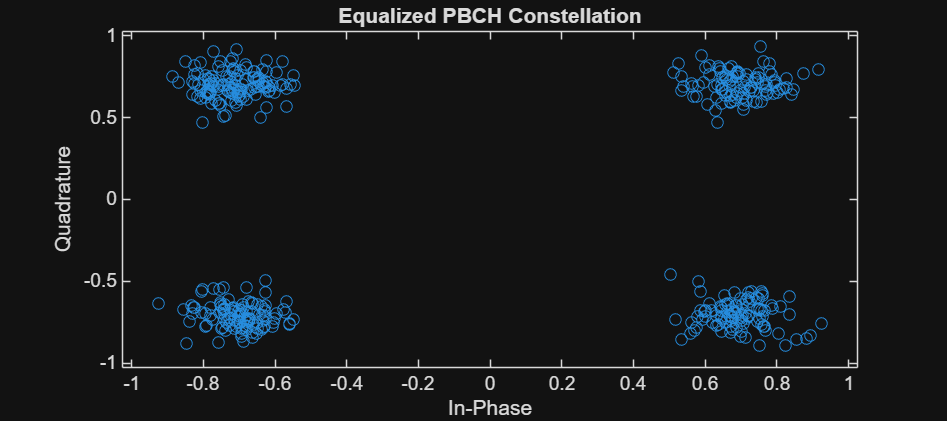

In [39]:

%% 1: Extract received PBCH symbols

% Get PBCH resource element indices for the detected cell
[pbch_indices, pbch_indices_info] = nrPBCHIndices(cellID_extracted);

% Extract PBCH symbols from the demodulated SS/PBCH block
pbch_rx = nrExtractResources(pbch_indices, rx_grid);

%% 2: Configure scrambling for PBCH according to 3GPP TS 38.211 Section 7.3.3.1

% 'v' is derived from the SSB index (ibar_SSB)
% L_max = 4 uses 2 LSBs; L_max = 8 or 64 uses all LSBs
if ref_burst.L_max == 4
    v = mod(ibar_SSB, 4);
else
    v = ibar_SSB;
end
ssb_index = v;

%% 3: PBCH Equalization using MMSE

% Extract the estimated channel for the PBCH resource elements
pbch_hest = nrExtractResources(pbch_indices, h_est);

% Perform MMSE equalization using the channel estimate and noise variance
[pbch_eq, csi] = nrEqualizeMMSE(pbch_rx, pbch_hest, n_var);

% Replicate CSI across coded bits
Qm = pbch_indices_info.G / pbch_indices_info.Gd;
csi = repmat(csi.', Qm, 1);
csi = reshape(csi, [], 1);

%% 4: Plot equalized PBCH constellation

figure('Position', [100 100 900 400])
plot(pbch_eq, 'o');
xlabel('In-Phase'); ylabel('Quadrature');
title('Equalized PBCH Constellation');

% Set axis limits slightly larger than max magnitude
m = max(abs([real(pbch_eq(:)); imag(pbch_eq(:))])) * 1.1;
axis([-m m -m m]);

In [40]:

%% 5: PBCH Demodulation

% Decode PBCH to obtain the bit estimates
pbch_bits = nrPBCHDecode(pbch_eq, cellID_extracted, v, n_var);

%% 6: Calculate RMS PBCH EVM

% Generate reference PBCH symbols for EVM calculation
pbch_ref = nrPBCH(pbch_bits < 0, cellID_extracted, v);

% Compute RMS EVM in percentage
pbch_EVM_rms = nrEVM(pbch_eq, pbch_ref) * 100;

% Display calculated EVM
disp([' PBCH RMS EVM: ' num2str(pbch_EVM_rms, '%0.3f') '%']);

 PBCH RMS EVM: 11.113%


####  BCH decoding
-  Apply channel state information (CSI) from the MMSE equalizer to PBCH bit estimates.
-  Perform BCH decoding: rate recovery, polar decoding, CRC check, descrambling, and separate transport block bits from additional payload bits.
-  Display BCH CRC and stop processing if errors are detected.
-  Use additional payload bits (msb\_idx\_offset) to determine full SSB index or subcarrier offset depending on L\_max.
-  Display the calculated SSB index.

After PBCH demodulation, the receiver has:

-  Soft bit estimates (pbchBits)
-  Channel quality info (csi)
-  Cell ID and SSB index

Now we perform BCH decoding, which gives:

-  The BCH transport block (24 MIB bits)
-  Timing\-related payload bits (like SFN and half\-frame number)
-  Validation via CRC

This converts physical bits (PBCH) → logical system information (BCH).


Multiplying by CSI weights soft bits based on their reliability. Mathematically:


$$L_i^{^{\prime } } =L_i \times w_i$$
#### BCH decoding

a. Rate Recovery: Reconstruct the original codeword length (E = 864 bits for PBCH). Soft bits are rearranged and punctured/repeated appropriately.


b. Polar Decoding: Polar decoding estimates the original bits using Successive Cancellation List (SCL) decoding.


c. CRC Decoding: BCH uses a 24\-bit CRC for integrity checking. After decoding, the CRC is verified.


d. PBCH Descrambling: After successful CRC, PBCH bits are descrambled using the cell ID (cellID) and scrambling parameter v. This restores the original transmitted bit sequence before channel coding.


e. Separate Payload Fields:

-  24 bits \- BCH transport block (trblk) \-> MIB
-  8 bits \- additional timing\-related payload bits (A...A+7)

Identify which SSB within the burst was detected.


For L\_max = 64 (FR2): $ssbIndex=v+8\cdot (MSBsfromBCH)$


For L\_max = 4 or 8 (FR1): $k_{SSB} =MSB_{\textrm{offset}} \times 16$



In [41]:
%% BCH Decoding

disp(' -- BCH decoding -- ');

 -- BCH decoding --

In [42]:

%% 1: Apply CSI to PBCH bit estimates

% Weight PBCH bits with channel state information (from MMSE equalizer)
pbch_bits_csi = pbch_bits .* csi;

%% 2: Perform BCH decoding

% Polar decoding list length
polar_list_length = 8;

% Decode BCH: rate recovery, polar decoding, CRC check, descrambling,
% and extraction of the 24 BCH transport block bits ('trblk') and
% 8 additional timing-related payload bits
[~, crc_BCH, trblk, sfn_4lsb, n_half_frame, msb_idx_offset] = ...
    nrBCHDecode(pbch_bits_csi, polar_list_length, ref_burst.L_max, cellID_extracted);

% Display BCH CRC
disp([' BCH CRC: ' num2str(crc_BCH)]);

 BCH CRC: 0

In [43]:

%% 3: Stop processing if BCH was received with errors

if crc_BCH
    disp(' BCH CRC is not zero. Stopping MIB/SIB1 processing.');
    return
end

%% 4: Set SSB index and k_SSB using additional payload bits

% For L_max = 64, use 3 MSBs to calculate full SSB index
% For L_max = 4 or 8, set subcarrier offset k_SSB
if ref_burst.L_max == 64
    ssb_index = ssb_index + (bit2int(msb_idx_offset, 3) * 8);
    k_SSB = 0;
else
    k_SSB = msb_idx_offset * 16;
end

% Display the calculated SSB index
disp([' SSB index: ' num2str(ssb_index)]);

 SSB index: 0


#### MIB and BCH Parsing
-  Parse MIB from BCH transport block.
-  Combine MIB bits with PBCH payload to reconstruct 10\-bit SFN.
-  Determine subcarrier offset k\_SSB
-  Build initialSystemInfo structure (cell\-wide parameters)
-  Display decoded MIB content
-  Verify if CORESET 0 is available for further system access

The 24\-bit BCH transport block trblk corresponds to:


1 leading bit $\to$ message type (0 = valid MIB, 1 = empty (no MIB))


Remaining 23 bits $\to$ actual MIB contents. So only bits 2–24 are parsed using the function.


The MIB provides 6 MSBs of the 10\-bit System Frame Number (SFN), and the remaining 4 LSBs are obtained from the PBCH payload bits.


$$N_{\textrm{Frame}} =({\textrm{MIB.SFN}}_{\textrm{MSB}} \ll 4)+{\textrm{sfn}}_{\textrm{LSB}}$$

Subcarrier Offset $k_{SSB}$ is calcilated as:


 $k_{SSB} =k_{SSB}^{\textrm{MIB}} +16\times k_{SSB}^{\textrm{PBCH}}$ �


Initial System Information Structure:

-  MIB fields (DL bandwidth, SCS, PBCH info, etc.)
-  SFN (from MSB + LSB combination)
-  $k_{SSB}$ (subcarrier offset)
-  $L_{max}$ (total number of SSBs)

This forms the initialSystemInfo structure, representing the first level of system configuration known to the UE.


CORESET 0 (Control Resource Set 0) is used for Type0\-PDCCH search space, required for decoding SIB1. Its presence depends on both the block pattern (Case A/B/C) and $k_{SSB}$ (subcarrier offset).


$$k_{SSB} \le k_{SSB}^{\max } ~~\to ~~\textrm{CORESET}\;\textrm{0}\;\textrm{available}$$

If not, UE cannot decode SIB1 in this configuration.


In [44]:
%% MIB and BCH Parsing

disp(' -- Parsing BCH/MIB -- ');

 -- Parsing BCH/MIB --

In [45]:

%% 1: Parse decoded BCH transport block into MIB

% The BCH transport block 'trblk' is an RRC BCCH-BCH message
% It contains a leading bit (message type) and 23 bits corresponding to the MIB
% Skip the leading bit and parse the remaining 23 bits
mib = fromBits(MIB, trblk(2:end));

%% 2: Create initial system information structure

% Construct a structure containing complete initial system information
% Includes SFN reconstruction from 6 MSBs in MIB and 4 LSBs from PBCH
% Also includes MSB of k_SSB for L_max = 4 or 8
initial_system_info = initSystemInfo(mib, sfn_4lsb, k_SSB, ref_burst.L_max);

% Display the MIB content
disp(' BCH/MIB Content:');

 BCH/MIB Content:

In [46]:
disp(initial_system_info);

                     NFrame: 0
    SubcarrierSpacingCommon: 15
                      k_SSB: 0
          DMRSTypeAPosition: 3
            PDCCHConfigSIB1: [1x1 struct]
                 CellBarred: 0
       IntraFreqReselection: 0

In [47]:

%% 3: Check for presence of CORESET 0 (Type0-PDCCH common search space)

% According to TS 38.213 Section 4.1, CORESET 0 may not be present if k_SSB > k_SSB_max
if ~isCORESET0Present(ref_burst.BlockPattern, initial_system_info.k_SSB)
    fprintf('CORESET 0 is not present (k_SSB > k_SSB_max).\n');
    return
end
